# Approach 4: R3d-18+ custom(approach 2) 3dcnn head- best model

# PHASE 1 — Model Setup (R3D-18 + Custom Head)

In [ ]:
import os
import torch
import torch.nn as nn
from torchvision.models.video import r3d_18

device=torch.device("cuda" if torch.cuda.is_available() else "cpu")  # select GPU if available
backbone=r3d_18(weights="DEFAULT").to(device)  # load pretrained R3D-18 for spatiotemporal features
print("Loaded pretrained R3D-18 backbone. Device:", device)

Loaded pretrained R3D-18 backbone. Device: cpu


In [ ]:
import torch
class Simple3DCNN(nn.Module):
    def __init__(self,num_classes=4):
        super(Simple3DCNN,self).__init__()

        # existing 3D-CNN architecture used
        self.features=nn.Sequential(
            nn.Conv3d(3,64,kernel_size=3,stride=1,padding=1),  # basic 3D conv stem
            nn.ReLU(),
            nn.MaxPool3d(kernel_size=(1,2,2)),  # reduce spatial size
            nn.Conv3d(64,128,kernel_size=3,stride=1,padding=1),  # mid level spatiotemporal features
            nn.ReLU(),
            nn.MaxPool3d(kernel_size=(2,2,2)),
            nn.Conv3d(128,256,kernel_size=3,stride=1,padding=1),  # deeper feature block
            nn.ReLU(),
            nn.MaxPool3d(kernel_size=(2,2,2))
        )

        # compute flattened size automatically
        with torch.no_grad():
            dummy_input=torch.zeros(1,3,16,112,112)
            dummy_output=self.features(dummy_input)
            self.flat_features=dummy_output.view(1,-1).size(1)
            
        self.classifier=nn.Sequential(
            nn.Linear(self.flat_features,512),  # compressed feature embedding
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512,num_classes)  # final logits
        )
    def forward(self,x):
        x=self.features(x)
        x=x.view(x.size(0),-1)
        x=self.classifier(x)
        return x

device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
model=Simple3DCNN(num_classes=4).to(device)


Flattened features: 200704


In [ ]:
# Load previous Simple3DCNN classifier head
base_model = Simple3DCNN(num_classes=4)
base_model.load_state_dict(torch.load("../models/3dcnn_model.pt", map_location="cpu"))
tennis_classifier = base_model.classifier  # reuse the learned classifier head
print("Loaded tennis classifier from saved 3dcnn_model.pt")


Flattened features: 200704
Loaded tennis classifier from saved 3dcnn_model.pt


In [ ]:
import torch

# Replacing the final FC layer with head compatible with loaded classifier
backbone.fc =nn.Sequential(nn.Linear(backbone.fc.in_features, 512),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(512, 4)).to(device)

# copying the final linear weights if shapes match
try:
    with torch.no_grad():
        backbone.fc[3].weight.copy_(tennis_classifier[3].weight)
        backbone.fc[3].bias.copy_(tennis_classifier[3].bias)
    print("Copied classifier weights from saved baseline into backbone.fc")
except Exception as e:
    print("Could not copy classifier weights (shapes might differ). Continuing with initialized head.")
    print(e)

Copied classifier weights from saved baseline into backbone.fc


In [ ]:
# Freeze all params first
for p in backbone.parameters():
    p.requires_grad =False

# unfreeze last block and the fc head for fine tuning
for p in backbone.layer4.parameters():
    p.requires_grad=True
for p in backbone.fc.parameters():
    p.requires_grad=True

# summary of trainable params
trainable =sum(p.numel() for p in backbone.parameters() if p.requires_grad)
total= sum(p.numel() for p in backbone.parameters())
print(f"Trainable params: {trainable} / {total}")


Trainable params: 25173508 / 33430980


# PHASE 2 — Dataset construction (real + synthetic)

In [ ]:
# Cell 6
# Datasets + loaders + criterion + optimizer (real + synthetic mixed for train)
import numpy as np
import random
import cv2
from pathlib import Path
from torch.utils.data import Dataset, DataLoader, ConcatDataset, WeightedRandomSampler

# data config
classes= ["forehand","backhand","serves","nostroke"]
frames_per_clip =16
H,W=112, 112
batch_size= 4
num_workers =0
pin_memory= False

# Real data using new split I created
train_real_root= "../data1/train"
val_real_root = "../data1/val"
test_real_root= "../data1/test"

# Synthetic folder created earlier
synthetic_root= "../synthetic"

## Data processing

In [ ]:
# normalization constants matching training expectation
MEAN = [0.45, 0.45, 0.45]
STD  =[0.225, 0.225, 0.225]

class NormalizeClip:
    def __init__(self,mean,std):
        # reshape mean,std for 3D video tensors
        self.mean=torch.tensor(mean).view(3,1,1,1)
        self.std=torch.tensor(std).view(3,1,1,1)

    def __call__(self,clip):
        # clip [C,T,H,W] normalized per channel
        return (clip-self.mean.to(clip.device))/self.std.to(clip.device)

norm_transform=NormalizeClip(MEAN,STD)

In [ ]:
# ---------- VideoDataset (real) ----------
class VideoDataset(Dataset):
    def __init__(self,root_dir,classes,frames_per_clip=16,transform=None):# prepare video paths list
        self.root_dir=root_dir
        self.classes=classes
        self.frames_per_clip=frames_per_clip
        self.transform=transform
        self.samples=[]
        for label,cls in enumerate(classes):
            class_dir=os.path.join(root_dir,cls)
            if not os.path.isdir(class_dir): continue
            videos=sorted([v for v in os.listdir(class_dir) if v.endswith(".mp4")])
            for v in videos:
                self.samples.append((os.path.join(class_dir,v),label))  # store video path

    def __len__(self): return len(self.samples)

    def _load_frames(self,video_path):# load uniformly sampled frames
        cap=cv2.VideoCapture(video_path)
        total=int(cap.get(cv2.CAP_PROP_FRAME_COUNT)) or 1
        idxs=np.linspace(0,total-1,self.frames_per_clip,dtype=int)
        frames=[]
        last_valid=None

        for i in idxs:
            cap.set(cv2.CAP_PROP_POS_FRAMES,int(i))
            ret,frame=cap.read()
            if not ret:
                frame=last_valid.copy() if last_valid is not None else np.zeros((H,W,3),dtype=np.uint8)  # fallback frame
            else:
                last_valid=frame.copy()
            frame=cv2.cvtColor(frame,cv2.COLOR_BGR2RGB)
            frame=cv2.resize(frame,(W,H))
            frames.append(frame)  # append sampled frame

        cap.release()
        arr=np.stack(frames,axis=0).astype(np.float32)/255.0  # normalize range
        tensor=torch.from_numpy(arr).permute(3,0,1,2)   # convert to [C,T,H,W]
        return tensor

    def __getitem__(self,idx):# return clip and label
        path,label=self.samples[idx]
        clip=self._load_frames(path)  # load video clip
        if self.transform: clip=self.transform(clip)  # apply normalization
        return clip,label


## Building combined data

In [ ]:
# build datasets
real_train=VideoDataset(train_real_root,classes,frames_per_clip=frames_per_clip,transform=norm_transform)  # load real training data
real_val=VideoDataset(val_real_root,classes,frames_per_clip=frames_per_clip,transform=norm_transform)   # load real validation data
real_test=VideoDataset(test_real_root,classes,frames_per_clip=frames_per_clip,transform=norm_transform)    # load real test data
synth_ds=SyntheticTensorDataset(synthetic_root,classes,transform=norm_transform)   # load synthetic dataset

print(f"Counts -> real_train:{len(real_train)} | real_val:{len(real_val)} | real_test:{len(real_test)} | synth:{len(synth_ds)}")

# creating mixed train loader via WeightedRandomSampler
from torch.utils.data import ConcatDataset,WeightedRandomSampler

combined=ConcatDataset([real_train,synth_ds])  # merge real+synthetic datasets
len_real=len(real_train)
len_synth=len(synth_ds)

# desired ratio of real samples
desired_real_fraction=0.75  # target real percentage

def compute_synth_weight(N_real,N_synth,desired_real_fraction=0.75,real_weight=1.0):
    # compute sampling weight for synthetic
    p=desired_real_fraction
    if N_synth==0: return 1.0
    return (real_weight*N_real*(1.0-p))/(p*N_synth)



In [ ]:
synth_weight=compute_synth_weight(len_real,len_synth,desired_real_fraction)  # compute synthetic weight

weights=np.ones(len(combined),dtype=np.float32)  # init sampling weights
weights[:len_real]=1.0      # weight real samples
weights[len_real:]=float(synth_weight)# weight synthetic samples

sampler=WeightedRandomSampler(weights=weights,num_samples=len(combined),replacement=True)  # balanced sampler
train_loader=DataLoader(combined,batch_size=batch_size,sampler=sampler,
                        num_workers=num_workers,pin_memory=pin_memory)  # mixed train loader

# Val/test real data only loaders
val_loader=DataLoader(real_val,batch_size=batch_size,shuffle=False,num_workers=num_workers,pin_memory=pin_memory)  # validation loader
test_loader=DataLoader(real_test,batch_size=batch_size,shuffle=False,num_workers=num_workers,pin_memory=pin_memory)    # test loader

print(f"Train loader batches:{len(train_loader)} | Val batches:{len(val_loader)} | Test batches:{len(test_loader)}")
print(f"Sampler weights -> real=1.0 synth:{synth_weight:.5f} (target real fraction {desired_real_fraction})")

# criterion and optimizer
criterion=nn.CrossEntropyLoss()  # classification loss
optimizer=torch.optim.Adam(filter(lambda p:p.requires_grad,backbone.parameters()),lr=1e-4)  # trainable params optimizer
print("Criterion and optimizer ready.")


Counts -> real_train: 30 | real_val: 36 | real_test: 34 | synth: 240
Train loader batches: 68 | Val batches: 9 | Test batches: 9
Sampler weights -> real=1.0 synth=0.04167 (target real fraction 0.75)
Criterion and optimizer ready.


# PHASE 3 — Training loop (Mixed Training)

Epoch 1/10 [TRAIN]:   7%|███▊                                               | 5/68 [00:21<04:16,  4.08s/it, loss=1.1414][h264 @ 0x15b82ed00] mmco: unref short failure
[h264 @ 0x15b82ed00] mmco: unref short failure
[h264 @ 0x15b82ed00] mmco: unref short failure
[h264 @ 0x15b82ed00] mmco: unref short failure
[h264 @ 0x15b82ed00] mmco: unref short failure
[h264 @ 0x15b82ed00] mmco: unref short failure
[h264 @ 0x15b82ed00] mmco: unref short failure
[h264 @ 0x15b82ed00] mmco: unref short failure
Epoch 1/10 [TRAIN]:   9%|████▌                                              | 6/68 [00:25<04:16,  4.14s/it, loss=0.8904][h264 @ 0x10e3f7f20] mmco: unref short failure
[h264 @ 0x10e3f7f20] mmco: unref short failure
[h264 @ 0x10e3f7f20] mmco: unref short failure
[h264 @ 0x10e3f7f20] mmco: unref short failure
[h264 @ 0x10e3f7f20] mmco: unref short failure
[h264 @ 0x10e3f7f20] mmco: unref short failure
[h264 @ 0x10e3f7f20] mmco: unref short failure
[h264 @ 0x10e3f7f20] mmco: unref short failure
Epoch 1/


Epoch [1/10] Summary:
 Train Loss: 0.4764 | Train Acc: 85.93%
 Val Loss:   0.1000 | Val Acc:   97.22%

New best model saved to ../models/best_r3d18_with_synth.pt (Val Acc 97.22%)


Epoch 2/10 [TRAIN]:   0%|                                                                        | 0/68 [00:00<?, ?it/s][h264 @ 0x10e3f2640] mmco: unref short failure
[h264 @ 0x10e3f2640] mmco: unref short failure
[h264 @ 0x10e3f2640] mmco: unref short failure
[h264 @ 0x10e3f2640] mmco: unref short failure
[h264 @ 0x10e3f2640] mmco: unref short failure
[h264 @ 0x10e3f2640] mmco: unref short failure
[h264 @ 0x10e3f2640] mmco: unref short failure
[h264 @ 0x10e3f2640] mmco: unref short failure
[h264 @ 0x10e3f2760] mmco: unref short failure
[h264 @ 0x10e3f2760] mmco: unref short failure
[h264 @ 0x10e3f2760] mmco: unref short failure
[h264 @ 0x10e3f2760] mmco: unref short failure
[h264 @ 0x10e3f2760] mmco: unref short failure
[h264 @ 0x10e3f2760] mmco: unref short failure
[h264 @ 0x10e3f2760] mmco: unref short failure
[h264 @ 0x10e3f2760] mmco: unref short failure
Epoch 2/10 [TRAIN]:   3%|█▌                                                 | 2/68 [00:07<04:10,  3.80s/it, loss=0.7892][h264 @ 


Epoch [2/10] Summary:
 Train Loss: 0.1580 | Train Acc: 95.93%
 Val Loss:   0.0762 | Val Acc:   97.22%

Best so far: 97.22%


Epoch 3/10 [TRAIN]:   0%|                                                                        | 0/68 [00:00<?, ?it/s][h264 @ 0x15af67110] mmco: unref short failure
[h264 @ 0x15af67110] mmco: unref short failure
[h264 @ 0x15af67110] mmco: unref short failure
[h264 @ 0x15af67110] mmco: unref short failure
[h264 @ 0x15af67110] mmco: unref short failure
[h264 @ 0x15af67110] mmco: unref short failure
[h264 @ 0x15af67110] mmco: unref short failure
[h264 @ 0x15af67110] mmco: unref short failure
Epoch 3/10 [TRAIN]:   1%|▊                                                  | 1/68 [00:03<03:47,  3.39s/it, loss=0.0762][h264 @ 0x10e3ff4b0] mmco: unref short failure
[h264 @ 0x10e3ff4b0] mmco: unref short failure
[h264 @ 0x10e3ff4b0] mmco: unref short failure
[h264 @ 0x10e3ff4b0] mmco: unref short failure
[h264 @ 0x10e3ff4b0] mmco: unref short failure
[h264 @ 0x10e3ff4b0] mmco: unref short failure
[h264 @ 0x10e3ff4b0] mmco: unref short failure
[h264 @ 0x10e3ff4b0] mmco: unref short failure
Epoch 3/


Epoch [3/10] Summary:
 Train Loss: 0.0781 | Train Acc: 98.15%
 Val Loss:   0.0717 | Val Acc:   97.22%

Best so far: 97.22%


Epoch 4/10 [TRAIN]:   0%|                                                                        | 0/68 [00:00<?, ?it/s][h264 @ 0x10e3fbd70] mmco: unref short failure
[h264 @ 0x10e3fbd70] mmco: unref short failure
[h264 @ 0x10e3fbd70] mmco: unref short failure
[h264 @ 0x10e3fbd70] mmco: unref short failure
[h264 @ 0x10e3fbd70] mmco: unref short failure
[h264 @ 0x10e3fbd70] mmco: unref short failure
[h264 @ 0x10e3fbd70] mmco: unref short failure
[h264 @ 0x10e3fbd70] mmco: unref short failure
Epoch 4/10 [TRAIN]:   1%|▊                                                  | 1/68 [00:04<04:56,  4.43s/it, loss=0.0163][h264 @ 0x10e3fbb90] mmco: unref short failure
[h264 @ 0x10e3fbb90] mmco: unref short failure
[h264 @ 0x10e3fbb90] mmco: unref short failure
[h264 @ 0x10e3fbb90] mmco: unref short failure
[h264 @ 0x10e3fbb90] mmco: unref short failure
[h264 @ 0x10e3fbb90] mmco: unref short failure
[h264 @ 0x10e3fbb90] mmco: unref short failure
[h264 @ 0x10e3fbb90] mmco: unref short failure
[h264 @ 


Epoch [4/10] Summary:
 Train Loss: 0.0663 | Train Acc: 97.78%
 Val Loss:   0.1180 | Val Acc:   94.44%

Best so far: 97.22%


Epoch 5/10 [TRAIN]:   1%|▊                                                  | 1/68 [00:04<05:01,  4.49s/it, loss=0.0044][h264 @ 0x15af6a110] mmco: unref short failure
[h264 @ 0x15af6a110] mmco: unref short failure
[h264 @ 0x15af6a110] mmco: unref short failure
[h264 @ 0x15af6a110] mmco: unref short failure
[h264 @ 0x15af6a110] mmco: unref short failure
[h264 @ 0x15af6a110] mmco: unref short failure
[h264 @ 0x15af6a110] mmco: unref short failure
[h264 @ 0x15af6a110] mmco: unref short failure
Epoch 5/10 [TRAIN]:   6%|███                                                | 4/68 [00:14<03:28,  3.25s/it, loss=0.0149][h264 @ 0x15af692c0] mmco: unref short failure
[h264 @ 0x15af692c0] mmco: unref short failure
[h264 @ 0x15af692c0] mmco: unref short failure
[h264 @ 0x15af692c0] mmco: unref short failure
[h264 @ 0x15af692c0] mmco: unref short failure
[h264 @ 0x15af692c0] mmco: unref short failure
[h264 @ 0x15af692c0] mmco: unref short failure
[h264 @ 0x15af692c0] mmco: unref short failure
Epoch 5/


Epoch [5/10] Summary:
 Train Loss: 0.0857 | Train Acc: 98.15%
 Val Loss:   0.1217 | Val Acc:   97.22%

Best so far: 97.22%


Epoch 6/10 [TRAIN]:   0%|                                                                        | 0/68 [00:00<?, ?it/s][h264 @ 0x15af699c0] mmco: unref short failure
[h264 @ 0x15af699c0] mmco: unref short failure
[h264 @ 0x15af699c0] mmco: unref short failure
[h264 @ 0x15af699c0] mmco: unref short failure
[h264 @ 0x15af699c0] mmco: unref short failure
[h264 @ 0x15af699c0] mmco: unref short failure
[h264 @ 0x15af699c0] mmco: unref short failure
[h264 @ 0x15af699c0] mmco: unref short failure
Epoch 6/10 [TRAIN]:   4%|██▎                                                | 3/68 [00:11<04:07,  3.80s/it, loss=0.0134][h264 @ 0x15b832860] mmco: unref short failure
[h264 @ 0x15b832860] mmco: unref short failure
[h264 @ 0x15b832860] mmco: unref short failure
[h264 @ 0x15b832860] mmco: unref short failure
[h264 @ 0x15b832860] mmco: unref short failure
[h264 @ 0x15b832860] mmco: unref short failure
[h264 @ 0x15b832860] mmco: unref short failure
[h264 @ 0x15b832860] mmco: unref short failure
Epoch 6/


Epoch [6/10] Summary:
 Train Loss: 0.1051 | Train Acc: 98.52%
 Val Loss:   0.1114 | Val Acc:   97.22%

Best so far: 97.22%


Epoch 7/10 [TRAIN]:   0%|                                                                        | 0/68 [00:00<?, ?it/s][h264 @ 0x10e3dbc80] mmco: unref short failure
[h264 @ 0x10e3dbc80] mmco: unref short failure
[h264 @ 0x10e3dbc80] mmco: unref short failure
[h264 @ 0x10e3dbc80] mmco: unref short failure
[h264 @ 0x10e3dbc80] mmco: unref short failure
[h264 @ 0x10e3dbc80] mmco: unref short failure
[h264 @ 0x10e3dbc80] mmco: unref short failure
[h264 @ 0x10e3dbc80] mmco: unref short failure
[h264 @ 0x15af68160] mmco: unref short failure
[h264 @ 0x15af68160] mmco: unref short failure
[h264 @ 0x15af68160] mmco: unref short failure
[h264 @ 0x15af68160] mmco: unref short failure
[h264 @ 0x15af68160] mmco: unref short failure
[h264 @ 0x15af68160] mmco: unref short failure
[h264 @ 0x15af68160] mmco: unref short failure
[h264 @ 0x15af68160] mmco: unref short failure
Epoch 7/10 [TRAIN]:   4%|██▎                                                | 3/68 [00:13<04:54,  4.53s/it, loss=0.0280][h264 @ 


Epoch [7/10] Summary:
 Train Loss: 0.0423 | Train Acc: 98.89%
 Val Loss:   0.1667 | Val Acc:   94.44%

Best so far: 97.22%


Epoch 8/10 [TRAIN]:   3%|█▌                                                 | 2/68 [00:10<05:54,  5.38s/it, loss=0.0055][h264 @ 0x10e3e02c0] mmco: unref short failure
[h264 @ 0x10e3e02c0] mmco: unref short failure
[h264 @ 0x10e3e02c0] mmco: unref short failure
[h264 @ 0x10e3e02c0] mmco: unref short failure
[h264 @ 0x10e3e02c0] mmco: unref short failure
[h264 @ 0x10e3e02c0] mmco: unref short failure
[h264 @ 0x10e3e02c0] mmco: unref short failure
[h264 @ 0x10e3e02c0] mmco: unref short failure
Epoch 8/10 [TRAIN]:   9%|████▌                                              | 6/68 [00:24<03:46,  3.65s/it, loss=0.0093][h264 @ 0x14ae62690] mmco: unref short failure
[h264 @ 0x14ae62690] mmco: unref short failure
[h264 @ 0x14ae62690] mmco: unref short failure
[h264 @ 0x14ae62690] mmco: unref short failure
[h264 @ 0x14ae62690] mmco: unref short failure
[h264 @ 0x14ae62690] mmco: unref short failure
[h264 @ 0x14ae62690] mmco: unref short failure
[h264 @ 0x14ae62690] mmco: unref short failure
[h264 @ 


Epoch [8/10] Summary:
 Train Loss: 0.0954 | Train Acc: 97.78%
 Val Loss:   0.1607 | Val Acc:   97.22%

Best so far: 97.22%


Epoch 9/10 [TRAIN]:   1%|▊                                                  | 1/68 [00:04<04:47,  4.30s/it, loss=0.1254][h264 @ 0x11d1d7e30] mmco: unref short failure
[h264 @ 0x11d1d7e30] mmco: unref short failure
[h264 @ 0x11d1d7e30] mmco: unref short failure
[h264 @ 0x11d1d7e30] mmco: unref short failure
[h264 @ 0x11d1d7e30] mmco: unref short failure
[h264 @ 0x11d1d7e30] mmco: unref short failure
[h264 @ 0x11d1d7e30] mmco: unref short failure
[h264 @ 0x11d1d7e30] mmco: unref short failure
Epoch 9/10 [TRAIN]:   4%|██▎                                                | 3/68 [00:11<04:01,  3.71s/it, loss=0.0214][h264 @ 0x11d1d7830] mmco: unref short failure
[h264 @ 0x11d1d7830] mmco: unref short failure
[h264 @ 0x11d1d7830] mmco: unref short failure
[h264 @ 0x11d1d7830] mmco: unref short failure
[h264 @ 0x11d1d7830] mmco: unref short failure
[h264 @ 0x11d1d7830] mmco: unref short failure
[h264 @ 0x11d1d7830] mmco: unref short failure
[h264 @ 0x11d1d7830] mmco: unref short failure
[h264 @ 


Epoch [9/10] Summary:
 Train Loss: 0.0273 | Train Acc: 99.63%
 Val Loss:   0.1529 | Val Acc:   97.22%

Best so far: 97.22%


Epoch 10/10 [TRAIN]:   1%|▋                                                 | 1/68 [00:03<03:27,  3.09s/it, loss=0.0012][h264 @ 0x11d1c9380] mmco: unref short failure
[h264 @ 0x11d1c9380] mmco: unref short failure
[h264 @ 0x11d1c9380] mmco: unref short failure
[h264 @ 0x11d1c9380] mmco: unref short failure
[h264 @ 0x11d1c9380] mmco: unref short failure
[h264 @ 0x11d1c9380] mmco: unref short failure
[h264 @ 0x11d1c9380] mmco: unref short failure
[h264 @ 0x11d1c9380] mmco: unref short failure
Epoch 10/10 [TRAIN]:   6%|██▉                                               | 4/68 [00:14<03:53,  3.65s/it, loss=0.0054][h264 @ 0x11d1c9380] mmco: unref short failure
[h264 @ 0x11d1c9380] mmco: unref short failure
[h264 @ 0x11d1c9380] mmco: unref short failure
[h264 @ 0x11d1c9380] mmco: unref short failure
[h264 @ 0x11d1c9380] mmco: unref short failure
[h264 @ 0x11d1c9380] mmco: unref short failure
[h264 @ 0x11d1c9380] mmco: unref short failure
[h264 @ 0x11d1c9380] mmco: unref short failure
[h264 @ 


Epoch [10/10] Summary:
 Train Loss: 0.0372 | Train Acc: 98.52%
 Val Loss:   0.0951 | Val Acc:   94.44%

Best so far: 97.22%


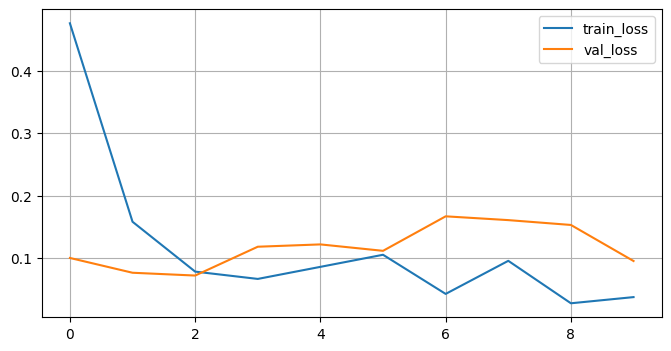

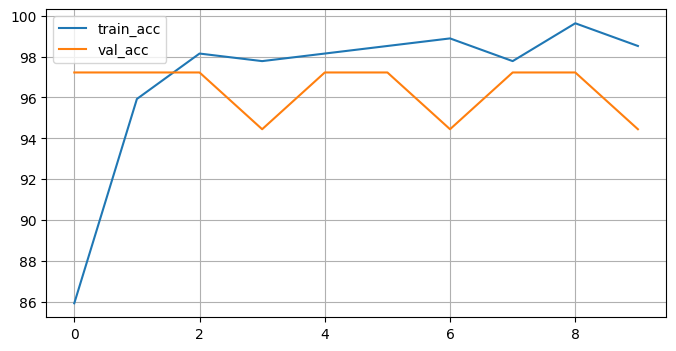

In [ ]:
from tqdm import tqdm
import os
import matplotlib.pyplot as plt

EPOCHS=10

train_losses=[]
train_accs=[]
val_losses=[]
val_accs=[]

save_path="../models/best_r3d18_with_synth.pt" #saving best model path
best_val_acc=0.0

for epoch in range(EPOCHS):

    # TRAIN: real+synthetic batches
    backbone.train()
    running_loss=0.0
    correct=0
    total=0
    prog=tqdm(train_loader,desc=f"Epoch {epoch+1}/{EPOCHS} [TRAIN]",ncols=120)

    for frames,labels in prog:
        frames,labels=frames.to(device),labels.to(device)
        optimizer.zero_grad()
        outputs=backbone(frames)
        loss=criterion(outputs,labels)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(backbone.parameters(),max_norm=5.0)  # limit gradient size
        optimizer.step()
        running_loss+=loss.item()
        _,preds=torch.max(outputs,1)
        correct+=(preds==labels).sum().item()
        total+=labels.size(0)
        prog.set_postfix({"loss":f"{loss.item():.4f}"})  # live loss update

    train_loss=running_loss/max(1,len(train_loader))
    train_acc=100*correct/max(1,total)
    train_losses.append(train_loss)
    train_accs.append(train_acc)

    # Validation real data evaluation
    backbone.eval()
    val_running_loss=0.0
    val_correct=0
    val_total=0
    prog_val=tqdm(val_loader,desc=f"Epoch {epoch+1}/{EPOCHS} [VAL]",ncols=120)

    with torch.no_grad():
        for frames,labels in prog_val:
            frames,labels=frames.to(device),labels.to(device)
            outputs=backbone(frames)
            loss=criterion(outputs,labels)
            val_running_loss+=loss.item()
            _,preds=torch.max(outputs,1)
            val_correct+=(preds==labels).sum().item()
            val_total+=labels.size(0)
            prog_val.set_postfix({"loss":f"{loss.item():.4f}"})

    val_loss=val_running_loss/max(1,len(val_loader))
    val_acc=100*val_correct/max(1,val_total)
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    # print epoch results
    print(f"\nEpoch [{epoch+1}/{EPOCHS}] Summary:")
    print(f" Train Loss:{train_loss:.4f} | Train Acc:{train_acc:.2f}%")
    print(f" Val Loss:{val_loss:.4f} | Val Acc:{val_acc:.2f}%\n")

    # save best validation model
    if val_acc>best_val_acc:
        best_val_acc=val_acc
        os.makedirs(os.path.dirname(save_path),exist_ok=True)
        torch.save(backbone.state_dict(),save_path)
        print(f"New best model saved to {save_path} (Val Acc {best_val_acc:.2f}%)")
    else:
        print(f"Best so far:{best_val_acc:.2f}%")

# plot training curves
plt.figure(figsize=(8,4));plt.plot(train_losses,label='train_loss');plt.plot(val_losses,label='val_loss');plt.legend();plt.grid(True);plt.show()
plt.figure(figsize=(8,4));plt.plot(train_accs,label='train_acc');plt.plot(val_accs,label='val_acc');plt.legend();plt.grid(True);plt.show()


# Phase 4- Data evaluation and monitoring

In [ ]:
# evaluating test accuracy, confusion matrix, classification report
import torch
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import os

# model loaded
# if best model saved earlier loading to validate
best_path= "../models/best_r3d18_with_synth.pt"
if os.path.exists(best_path):
    backbone.load_state_dict(torch.load(best_path, map_location=device))
    backbone.to(device)
    print("Loaded best checkpoint:", best_path)
backbone.eval()  # set eval mode

y_true=[]
y_pred=[]

with torch.no_grad():  # disable gradients
    for clips,labels in test_loader:
        clips=clips.to(device)
        labels=labels.to(device)
        outs=backbone(clips)
        preds=outs.argmax(1)  # predicted class ids
        y_true.extend(labels.cpu().numpy().tolist())
        y_pred.extend(preds.cpu().numpy().tolist())

labels_list=["forehand","backhand","serves","nostroke"]
print("Test accuracy:",accuracy_score(y_true,y_pred))
print("\nClassification report:\n")
print(classification_report(y_true,y_pred,target_names=labels_list,digits=4))
cm=confusion_matrix(y_true,y_pred)
print("Confusion matrix:\n",cm)


Loaded best checkpoint: ../models/best_r3d18_with_synth.pt


[h264 @ 0x177b42640] mmco: unref short failure
[h264 @ 0x177b42640] mmco: unref short failure
[h264 @ 0x177b42640] mmco: unref short failure
[h264 @ 0x177b42640] mmco: unref short failure
[h264 @ 0x177b42640] mmco: unref short failure
[h264 @ 0x177b42640] mmco: unref short failure
[h264 @ 0x177b42640] mmco: unref short failure
[h264 @ 0x177b42640] mmco: unref short failure
[h264 @ 0x177b42180] mmco: unref short failure
[h264 @ 0x177b42180] mmco: unref short failure
[h264 @ 0x177b42180] mmco: unref short failure
[h264 @ 0x177b42180] mmco: unref short failure
[h264 @ 0x177b42180] mmco: unref short failure
[h264 @ 0x177b42180] mmco: unref short failure
[h264 @ 0x177b42180] mmco: unref short failure
[h264 @ 0x177b42180] mmco: unref short failure
[h264 @ 0x177b430c0] mmco: unref short failure
[h264 @ 0x177b430c0] mmco: unref short failure
[h264 @ 0x177b430c0] mmco: unref short failure
[h264 @ 0x177b430c0] mmco: unref short failure
[h264 @ 0x177b430c0] mmco: unref short failure
[h264 @ 0x177

Test accuracy: 0.9705882352941176

Classification report:

              precision    recall  f1-score   support

    forehand     0.8750    1.0000    0.9333         7
    backhand     1.0000    1.0000    1.0000         7
      serves     1.0000    1.0000    1.0000         7
    nostroke     1.0000    0.9231    0.9600        13

    accuracy                         0.9706        34
   macro avg     0.9688    0.9808    0.9733        34
weighted avg     0.9743    0.9706    0.9710        34

Confusion matrix:
 [[ 7  0  0  0]
 [ 0  7  0  0]
 [ 0  0  7  0]
 [ 1  0  0 12]]


In [ ]:
print("Test accuracy:", accuracy_score(y_true, y_pred)) #printing the results again with test accuracy
print("\nClassification report:\n")
print(classification_report(y_true, y_pred, target_names=labels_list, digits=4))
cm = confusion_matrix(y_true, y_pred)
print("Confusion matrix:\n", cm)

Test accuracy: 0.9705882352941176

Classification report:

              precision    recall  f1-score   support

    forehand     0.8750    1.0000    0.9333         7
    backhand     1.0000    1.0000    1.0000         7
      serves     1.0000    1.0000    1.0000         7
    nostroke     1.0000    0.9231    0.9600        13

    accuracy                         0.9706        34
   macro avg     0.9688    0.9808    0.9733        34
weighted avg     0.9743    0.9706    0.9710        34

Confusion matrix:
 [[ 7  0  0  0]
 [ 0  7  0  0]
 [ 0  0  7  0]
 [ 1  0  0 12]]


In [ ]:
# train/val/test, and synthetic per class counts
import os
classes=["forehand","backhand","serves","nostroke"]
def count_mp4(root, classes):
    out ={}
    for c in classes:
        p=os.path.join(root, c)
        out[c]=len([f for f in os.listdir(p) if f.lower().endswith(".mp4")]) if os.path.isdir(p) else 0
    return out

print("Real train counts:",count_mp4("../data1/train", classes))
print("Real val   counts:",count_mp4("../data1/val", classes))
print("Real test  counts:",count_mp4("../data1/test", classes))

# Synthetic counts
synth_root = "../synthetic"
synth_counts = {c:len([f for f in os.listdir(os.path.join(synth_root,c)) if f.endswith(".pt")]) if os.path.isdir(os.path.join(synth_root,c)) else 0 for c in classes}
print("Synthetic counts:",synth_counts)


Real train counts: {'forehand': 6, 'backhand': 6, 'serves': 6, 'nostroke': 12}
Real val   counts: {'forehand': 7, 'backhand': 7, 'serves': 7, 'nostroke': 15}
Real test  counts: {'forehand': 7, 'backhand': 7, 'serves': 7, 'nostroke': 13}
Synthetic counts: {'forehand': 48, 'backhand': 48, 'serves': 48, 'nostroke': 96}
